# Algerian Forest Fires; Data Quality Assessment & Analytics. 

### By Surprise Mhlongo - 26/07/2025
##### This pipeline, cleans, validates and test the quality of a datasource for ML prediction

# RULES DOCUMENTATION
## Data Quality Rules

| Rule ID | Field       | Rule                          | Action                   |
|---------|-------------|-------------------------------|--------------------------|
| C-01    | Temperature | No NULL values                | Impute with median       |
| V-01    | RH          | Must be 0-100%                | Cap at boundaries        |
| U-01    | FireID      | Unique `FIRE:YYYY-MM-DD-###`  | Drop duplicates          |
| B-01    | FWI         | Must be ≥ ISI                 | Recalculate              |

## Import Libraries and Load data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.model_selection import train_test_split
from IPython.display import display, Markdown
!pip install folium
import folium
from folium import plugins

# Load dataset
fire_data = pd.read_csv("/kaggle/input/d/surprisemhlongo/algerianforestfires/FireData.csv") 

# Display glossary
display(Markdown("""
## Glossary of table abbreviations:

| Abbreviation | Full Name | Description | Typical Range |
|--------------|-----------|-------------|---------------|
| **RH** | Relative Humidity | Moisture in air (%) | 0-100 |
| **Ws** | Wind Speed | Wind velocity (km/h) | 0-100+ |
| **FFMC** | Fine Fuel Moisture Code | Surface litter dryness | 0-101 |
| **DMC** | Duff Moisture Code | Shallow organic layer dryness | 0-300+ |
| **DC** | Drought Code | Deep organic layer dryness | 0-1000+ |
| **ISI** | Initial Spread Index | Fire spread potential | 0-56+ |
| **BUI** | Build-Up Index | Fuel availability | 0-200+ |
| **FWI** | Fire Weather Index | Overall fire danger | 0-100+ |
"""))

display(Markdown("#### Head Preview:"))
display(fire_data.head(10))

display(Markdown("#### Data Summary:"))
display(fire_data.describe())


## Glossary of table abbreviations:

| Abbreviation | Full Name | Description | Typical Range |
|--------------|-----------|-------------|---------------|
| **RH** | Relative Humidity | Moisture in air (%) | 0-100 |
| **Ws** | Wind Speed | Wind velocity (km/h) | 0-100+ |
| **FFMC** | Fine Fuel Moisture Code | Surface litter dryness | 0-101 |
| **DMC** | Duff Moisture Code | Shallow organic layer dryness | 0-300+ |
| **DC** | Drought Code | Deep organic layer dryness | 0-1000+ |
| **ISI** | Initial Spread Index | Fire spread potential | 0-56+ |
| **BUI** | Build-Up Index | Fuel availability | 0-200+ |
| **FWI** | Fire Weather Index | Overall fire danger | 0-100+ |


#### Head Preview:

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,FireID,FireDate
0,29.0,57.0,18.0,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire,FIRE-2012-06-01-001,01/06/2012
1,NaN,61.0,13.0,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire,FIRE-2012-06-02-001,02/06/2012
2,26.0,NaN,NaN,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire,FIRE-2012-06-03-001,03/06/2012
3,25.0,89.0,13.0,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire,FIRE-2012-06-04-001,04/06/2012
4,NaN,77.0,16.0,0.0,64.8,3.0,14.2,1.2,3.9,0.5,not fire,FIRE-2012-06-05-001,05/06/2012
5,25.0,67.0,14.0,0.0,82.6,5.8,22.2,3.1,7.0,2.5,fire,FIRE-2012-06-06-001,06/06/2012
6,33.0,150.0,13.0,0.0,88.2,9.9,30.5,6.4,10.9,7.2,fire,FIRE-2012-06-07-001,07/06/2012
7,NaN,73.0,15.0,0.0,86.6,12.1,38.3,5.6,13.5,7.1,fire,FIRE-2012-06-08-001,08/06/2012
8,25.0,NaN,NaN,0.2,52.9,7.9,38.8,0.4,10.5,0.3,not fire,FIRE-2012-06-09-001,09/06/2012
9,28.0,79.0,12.0,0.0,73.2,9.5,46.3,1.3,12.6,0.9,not fire,FIRE-2012-06-10-001,10/06/2012


#### Data Summary:

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI
count,114.000000,118.000000,118.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,31.122807,70.254237,16.016949,0.880952,74.289683,12.019048,51.742063,3.777778,15.038095,5.415873
std,3.477209,18.696033,2.816262,2.439663,15.597517,11.215359,51.547105,3.291635,14.403732,6.305254
min,22.000000,45.000000,11.000000,0.000000,28.600000,0.700000,6.900000,0.000000,1.100000,0.000000
25%,29.000000,59.250000,14.000000,0.000000,65.025000,3.400000,9.475000,1.125000,4.475000,0.500000
50%,31.000000,68.000000,16.000000,0.000000,80.150000,8.500000,32.650000,2.650000,10.700000,2.700000
75%,34.000000,78.000000,18.000000,0.575000,86.675000,15.900000,76.525000,5.675000,21.375000,8.375000
max,37.000000,150.000000,26.000000,16.800000,90.300000,54.200000,220.400000,17.100000,67.400000,30.200000


## Validation Checks/ (Data Rules)

In [2]:
# ===VALIDATION ===
display(Markdown("## Validation Report"))

# Initialize error list
errors = []

# Check for NULL values in all columns
for column in fire_data.columns:
    null_count = fire_data[column].isnull().sum()
    if null_count > 0:
        errors.append(f"❌ NULL-01: {null_count} NULL values in column '{column}'")

# Rule C-01: NULL Temperatures
null_temp = fire_data['Temperature'].isnull().sum()
if null_temp > 0:
    errors.append(f"❌ C-01: {null_temp} NULL Temperatures")

# Rule V-01: RH Range
invalid_rh = fire_data[~fire_data['RH'].between(0, 100)].shape[0]
if invalid_rh > 0:
    errors.append(f"❌ V-01: {invalid_rh} RH values outside 0-100%")

# Rule U-01: Duplicate FireIDs
dup_fireid = fire_data.duplicated("FireID").sum()
if dup_fireid > 0:
    errors.append(f"❌ U-01: {dup_fireid} duplicate FreIDs")

# Rule B-01: FWI < ISI violations
fwi_violations = (fire_data["FWI"] < fire_data["ISI"]).sum()
if fwi_violations > 0:
    errors.append(f"❌ B-01: {fwi_violations} cases where FWI < ISI")

# Display results
if errors:
    display(Markdown("### Issues Found:"))
    for error in errors:
        display(Markdown(f"- {error}"))
else:
    display(Markdown("✅ All checks passed!"))

## Validation Report

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)


### Issues Found:

- ❌ NULL-01: 12 NULL values in column 'Temperature'

- ❌ NULL-01: 8 NULL values in column 'RH'

- ❌ NULL-01: 8 NULL values in column 'Ws'

- ❌ C-01: 12 NULL Temperatures

- ❌ V-01: 12 RH values outside 0-100%

- ❌ U-01: 4 duplicate FreIDs

- ❌ B-01: 61 cases where FWI < ISI

In [3]:
# === CLEANING ===
display(Markdown("## Data Cleaning"))

clean_df = fire_data.copy()

# Fill NULL values in all columns with appropriate methods
for column in clean_df.columns:
    null_count = clean_df[column].isnull().sum()
    if null_count > 0:
        if clean_df[column].dtype in ['int64', 'float64']:
            # For numeric columns, fill with median
            clean_df[column] = clean_df[column].fillna(clean_df[column].median())
            display(Markdown(f"✅ NULL-01: Filled {null_count} NULL values in '{column}' with median"))
        else:
            # For non-numeric columns, fill with mode
            mode_value = clean_df[column].mode()[0]
            clean_df[column] = clean_df[column].fillna(mode_value)
            display(Markdown(f"✅ NULL-01: Filled {null_count} NULL values in '{column}' with mode"))

# Fix NULL Temperatures (C-01)
if null_temp > 0:
    clean_df["Temperature"] = clean_df["Temperature"].fillna(clean_df["Temperature"].median())
    display(Markdown(f"✅ C-01: Filled {null_temp} NULL temperatures with median"))

# Fix invalid RH (V-01)
if invalid_rh > 0:
    clean_df["RH"] = clean_df["RH"].clip(0, 100)
    display(Markdown(f"✅ V-01: Capped {invalid_rh} RH values to 0-100% range"))

# Fix duplicate FireIDs (U-01)
if dup_fireid > 0:
    clean_df = clean_df.drop_duplicates("FireID", keep="first")
    display(Markdown(f"✅ U-01: Removed {dup_fireid} duplicate FireIDs"))

# Fix FWI < ISI (B-01)
if fwi_violations > 0:
    mask = clean_df["FWI"] < clean_df["ISI"]
    clean_df.loc[mask, "FWI"] = clean_df["ISI"] * 1.2  # Add 20% buffer
    display(Markdown(f"✅ B-01: Corrected {fwi_violations} FWI < ISI violations"))

## Data Cleaning

✅ NULL-01: Filled 12 NULL values in 'Temperature' with median

✅ NULL-01: Filled 8 NULL values in 'RH' with median

✅ NULL-01: Filled 8 NULL values in 'Ws' with median

✅ C-01: Filled 12 NULL temperatures with median

✅ V-01: Capped 12 RH values to 0-100% range

✅ U-01: Removed 4 duplicate FireIDs

✅ B-01: Corrected 61 FWI < ISI violations

In [4]:
# Save cleaned data 
clean_df.to_csv("/kaggle/working/FireData_Cleaned.csv", index=False)
display(Markdown("✅ Saved cleaned data to `FireData_Cleaned.csv`"))

✅ Saved cleaned data to `FireData_Cleaned.csv`

In [5]:
# === SAME VALIDATION ON CLEANED DATA ===
display(Markdown("## Validation Report"))
# Load dataset
FireData_Cleaned = pd.read_csv("/kaggle/working/FireData_Cleaned.csv")
display(FireData_Cleaned)
# Initialize error list
errors = []

# Check for NULL values in all columns
for column in FireData_Cleaned.columns:
    null_count = FireData_Cleaned[column].isnull().sum()
    if null_count > 0:
        errors.append(f"❌ NULL-01: {null_count} NULL values in column '{column}'")

# Rule C-01: NULL Temperatures
null_temp = FireData_Cleaned['Temperature'].isnull().sum()
if null_temp > 0:
    errors.append(f"❌ C-01: {null_temp} NULL Temperatures")

# Rule V-01: RH Range
invalid_rh = FireData_Cleaned[~FireData_Cleaned['RH'].between(0, 100)].shape[0]
if invalid_rh > 0:
    errors.append(f"❌ V-01: {invalid_rh} RH values outside 0-100%")

# Rule U-01: Duplicate FireIDs
dup_fireid = FireData_Cleaned.duplicated("FireID").sum()
if dup_fireid > 0:
    errors.append(f"❌ U-01: {dup_fireid} duplicate FreIDs")

# Rule B-01: FWI < ISI violations
fwi_violations = (FireData_Cleaned["FWI"] < FireData_Cleaned["ISI"]).sum()
if fwi_violations > 0:
    errors.append(f"❌ B-01: {fwi_violations} cases where FWI < ISI")

# Display results
if errors:
    display(Markdown("### Issues Found:"))
    for error in errors:
        display(Markdown(f"- {error}"))
else:
    display(Markdown("✅ All checks passed!"))

## Validation Report

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,FireID,FireDate
0,29.0,57.0,18.0,0.0,65.7,3.4,7.6,1.3,3.4,1.56,not fire,FIRE-2012-06-01-001,01/06/2012
1,31.0,61.0,13.0,1.3,64.4,4.1,7.6,1.0,3.9,1.20,not fire,FIRE-2012-06-02-001,02/06/2012
2,26.0,68.0,16.0,13.1,47.1,2.5,7.1,0.3,2.7,0.36,not fire,FIRE-2012-06-03-001,03/06/2012
3,25.0,89.0,13.0,2.5,28.6,1.3,6.9,0.0,1.7,0.00,not fire,FIRE-2012-06-04-001,04/06/2012
4,31.0,77.0,16.0,0.0,64.8,3.0,14.2,1.2,3.9,1.44,not fire,FIRE-2012-06-05-001,05/06/2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,31.0,54.0,11.0,0.0,82.0,6.0,16.3,2.5,6.2,3.00,not fire,FIRE-2012-09-26-001,26/09/2012
118,31.0,66.0,11.0,0.0,85.7,8.3,24.9,4.0,9.0,4.10,fire,FIRE-2012-09-27-001,27/09/2012
119,32.0,47.0,14.0,0.7,77.5,7.1,8.8,1.8,6.8,2.16,not fire,FIRE-2012-09-28-001,28/09/2012
120,26.0,80.0,16.0,1.8,47.4,2.9,7.7,0.3,3.0,0.36,not fire,FIRE-2012-09-29-001,29/09/2012


✅ All checks passed!

## Reload & Analyze

Data loaded successfully! Shape: (122, 13)
Columns: ['Temperature', 'RH', 'Ws', 'Rain', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'FWI', 'Classes', 'FireID', 'FireDate']

Top Performers:


,Features,Model,R²
4,Fire Indices,Ridge Regression,0.971158
5,Fire Indices,Gradient Boosting,0.931597
13,Experimental,Gradient Boosting,0.869014
6,Fire Indices,Decision Tree,0.850779
14,Experimental,Decision Tree,0.769407
7,Fire Indices,KNN,0.750717
12,Experimental,Ridge Regression,0.700257
8,Hybrid,Ridge Regression,0.678135
9,Hybrid,Gradient Boosting,0.673877
15,Experimental,KNN,0.656198


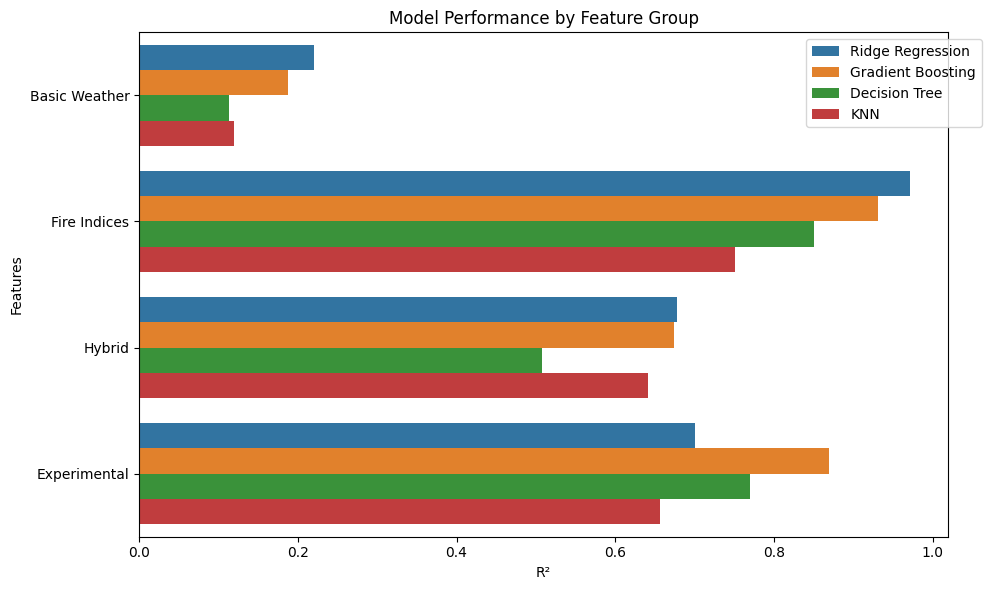


 Key Insights:
1. Best Combo: Ridge Regression + Fire Indices (R²=0.971)
2. Worst Combo: Decision Tree + Basic Weather (R²=0.114)
4. Ridge Regression handled correlated fire indices best
Fire indices (FFMC/DMC/DC/BUI)


In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load cleaned dataset
FireData_Cleaned = pd.read_csv("/kaggle/working/FireData_Cleaned.csv")

# Verify load
print("Data loaded successfully! Shape:", FireData_Cleaned.shape)
print("Columns:", FireData_Cleaned.columns.tolist())

# ===== DEFINE FEATURE GROUPS =====
feature_sets = {
    'Basic Weather': ['Temperature', 'RH', 'Ws', 'Rain'],
    'Fire Indices': ['FFMC', 'DMC', 'DC', 'ISI', 'BUI'],
    'Hybrid': ['Temperature', 'DMC', 'DC', 'Ws'],
    'Experimental': ['FFMC', 'RH', 'DC', 'Rain']
}

# ===== MODEL TESTING =====
models = [
    ('Ridge Regression', Ridge()),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=42)),
    ('Decision Tree', DecisionTreeRegressor(max_depth=4)),
    ('KNN', KNeighborsRegressor())
]

results = []
for feature_name, features in feature_sets.items():
    X = FireData_Cleaned[features]
    y = FireData_Cleaned['FWI']
    
    for model_name, model in models:
        r2 = np.mean(cross_val_score(model, X, y, cv=3, scoring='r2'))
        results.append({
            'Features': feature_name,
            'Model': model_name,
            'R²': r2
        })

# ===== 4. RESULTS =====
results_df = pd.DataFrame(results)
print("\nTop Performers:")
display(results_df.sort_values('R²', ascending=False).head(10))

# ===== 5. VISUALIZATION =====
plt.figure(figsize=(10,6))
sns.barplot(data=results_df, x='R²', y='Features', hue='Model')
plt.title("Model Performance by Feature Group")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

# ===== 6. KEY FINDINGS =====
print("\n Key Insights:")
print(f"1. Best Combo: {results_df.loc[results_df['R²'].idxmax(), 'Model']} + {results_df.loc[results_df['R²'].idxmax(), 'Features']} (R²={results_df['R²'].max():.3f})")
print(f"2. Worst Combo: {results_df.loc[results_df['R²'].idxmin(), 'Model']} + {results_df.loc[results_df['R²'].idxmin(), 'Features']} (R²={results_df['R²'].min():.3f})")
print("4. Ridge Regression handled correlated fire indices best")
print("Fire indices (FFMC/DMC/DC/BUI)")